In [1]:
import statsmodels.formula.api as smf # linear mixed effects model package

import matplotlib.pyplot as plt # used to create plots
import numpy as np # for creation of arrays
import pandas as pd # for making data frames
import math # for plotting CMC using log10 scale 

from sklearn.metrics import mean_squared_error, r2_score # statistics to score model 
from sklearn.model_selection import train_test_split # allows model to be tested on unseen data

In [2]:
def lmm_model(cmc_data, var1, var2, var3, var4, split, group_corr):
                  
    '''
    
    lmm_model:
    -----------
    
    A function that takes in the pandas dataframe and uses a linear mixed model to find the relationship between
    the descriptors and ln(CMC) for a training set and predicts using the test set
    
    Args:
    -----
    
    cmc_data: pandas dataframe containing ln(CMC) values and descriptors being used
    var1, var2, var3, var4: names of the variables being tested as strings so they can accessed in dataframe
    split: test/train split
    group_corr: boolean to describe whether group correction should be used 
    
    Returns:
    --------
    
    pred: predicted CMC values using the test data
    y_test: measured CMC values from the test data
    test_func_group: list of functional groups used to test model
    was_test: list of booleans to say if data was used to test the model (True) or to train it (False)
    
    '''
    
    all_cmc = list(cmc_data["CMC"]) # collects true CMC values from data frame
    
    indices = np.arange(len(all_cmc)) # list of integer values making up the indices of the data
    
    # splits the model into training and test data   
    train_data, test_data, train_ind, test_ind = train_test_split(cmc_data, indices, train_size = split, 
                                                                  random_state = 32)
    
    was_test = [] # returns boolean for each index to say if it was used as test data
    for ind in indices:
        if ind in train_ind:
            was_test.append(False)
        if ind in test_ind:
            was_test.append(True)
    
    # performs linear mixed model using descriptors specified for training set
    md = smf.mixedlm("ln_cmc ~ " + var1 + "+" + var2 + "+" + var3 + "+" + var4, train_data, 
                     groups = train_data["func_group"])
    mdf = md.fit(method = ["lbfgs"])
        
    grad_dict = mdf.params # finds dictonary of gradient values for each descriptor
    inter_dict = mdf.random_effects # finds dictonary of intercept value and correction for each head group
    
    # creates a test data set
    test_func_group = list(test_data["func_group"]); data1 = list(test_data[var1])
    data2 = list(test_data[var2]); data3 = list(test_data[var3]); data4 = list(test_data[var4])
        
    pred = []    
    for ind, test1 in enumerate(data1): # loops through data and predicts CMC value based on lmm
        test2 = data2[ind]; test3 = data3[ind]; test4 = data4[ind]
        group = test_func_group[ind]
        pred_val = predict_cmc_lmm(group, grad_dict, inter_dict, test1, test2, test3, test4, group_corr)
        pred.append(pred_val)
        
    y_test = list(test_data["CMC"]) # extracts the test set
    
    return(pred, y_test, test_func_group, was_test)

In [3]:
def lmm_stats_average(cmc_data, var1, var2, var3, var4, split, group_corr):
              
    '''
    
    lmm_stats_average:
    ------------------
    
    A function that takes in the pandas dataframe and finds the average values of the statistics coefficient
    of determination, root mean square error and mean absolute error from the linear mixed model relationship.
    
    Args:
    -----
    
    cmc_data: pandas dataframe containing ln(CMC) values and descriptors being used
    var1, var2, var3, var4: names of the variables being tested as strings so they can accessed in dataframe
    split: test/train split
    group_corr: boolean to describe whether group correction should be used
    
    Returns:
    --------
    
    rmse_av: average value of the root mean square error
    co_det_av: average value of the coefficient of determination
    mae_av: average value of the mean absolute error
    
    '''
    
    rmse_list = []; co_det_list = []; mae_list = []
    rmse_total = 0; co_det_total = 0; mae_total = 0
    count = 0
    
    all_func_group = list(cmc_data["func_group"])
    
    for rs in range(100):
    
        leave = False
        # splits the model into training and test data   
        train_data, test_data = train_test_split(cmc_data, train_size = split, random_state = rs)
        
        train_fg = list(train_data["func_group"])

        for fg in all_func_group: # needed to protect against errors if a head group is not in training set
            if fg not in train_fg:
                leave = True
        if leave:
            continue

        # performs linear mixed model using descriptors specified for training set
        md = smf.mixedlm("ln_cmc ~ " + var1 + "+" + var2 + "+" + var3 + "+" + var4, train_data, 
                         groups = train_data["func_group"])
        mdf = md.fit(method = ["lbfgs"])
        
        grad_dict = mdf.params # finds dictonary of gradient values for each descriptor
        inter_dict = mdf.random_effects # finds dictonary of intercept value and correction for each head group

        # creates a test data set
        func_group = list(test_data["func_group"]); cmc_vals = list(test_data["CMC"])
        data1 = list(test_data[var1]); data2 = list(test_data[var2]); data3 = list(test_data[var3])
        data4 = list(test_data[var4])
                
        pred = []
        for ind, test1 in enumerate(data1): # loops through data and predicts CMC value based on lmm
            test2 = data2[ind]; test3 = data3[ind]; test4 = data4[ind]
            group = func_group[ind]
            # gets out ln(CMC) and converts to CMC 
            pred_val = predict_cmc_lmm(group, grad_dict, inter_dict, test1, test2, test3, test4, group_corr)
            pred.append(pred_val)
            
        pred = np.array(pred)
        y_test = np.array(cmc_vals) # sets true value 
        
        mse = mean_squared_error(y_test, pred) # mean squared error of results
        rmse = np.sqrt(mean_squared_error(y_test, pred)) # root mean squared error 
        co_det = r2_score(y_test, pred) # coefficient of determination 
        mae = float(sum(abs(y_test-pred)) / len(y_test)) # mean absolute error 
        
        pred = list(pred); y_test = list(y_test)
        
        if co_det < 0.0: # assumes no correlation if below zero
            co_det = 0.0
            
        rmse_list.append(rmse); co_det_list.append(co_det); mae_list.append(mae)
            
        rmse_total += rmse # adds up the statistics values
        co_det_total += co_det
        mae_total += mae
        count += 1

    rmse_av = rmse_total / count # finds the average by dividing by the number of loops
    co_det_av = co_det_total / count
    mae_av = mae_total / count
    
    print("RMSE Mean: ", round(rmse_av, 2))
    print("Coeff of Det Mean: ", round(co_det_av, 2))
    print("MAE Mean: ", round(mae_av, 2))
    print("\n")
    
    return(rmse_av, co_det_av, mae_av)

In [4]:
def pred_true_cmc_data_lmm(cmc_vals_select, func_group, grad_dict, inter_dict, data1, data2, data3, data4, 
                           name1, name2, name3, name4, startfunc_pos, endfunc_pos, head_group, was_test, corr):
                      
    '''
    
    pred_true_cmc_data_lmm:
    ------------------------
    
    A function that takes in a dictionary of coefficient values for each descriptor, the group correction value
    found for each head group (each head group has a different y-intercept) and y-intercept found from 
    the linear mixed model and uses it to predict the CMC value based on the data given to train the 
    linear regression. It also finds the difference between the true CMC value and the predicted CMC value.
    
    Args:
    -----
    
    cmc_vals_select: CMC values for the data being tested
    func_group: list of head groups of each of the molecules
    grad_dict: dictionary of coefficent values for each descriptor as well as y-intercept value
    inter_dict: dictionary of each head group's correction to the y-intercept value
    data1, data2, data3, data4: list of values of four descriptors that were used to train the model
    name1, name2, name3, name4: names of four descriptors used to train the model (to access dictionary values)
    startfunc_pos: list to show were each new head group data starts
    endfunc_pos: list to show were each new head group data ends
    head_group: identifies type of molecule
    was_test: list of booleans to say if data was used to test the model (True) or to train it (False)
    corr: boolean used to describe if the group correction should be used in the predictions in order to see
    how well it can predict without it
    
    Returns:
    --------
    
    sep_cmc_pred: list of lists of the predicted CMC value separated into different lists based on the head group
    sep_cmc_diff: list of lists of difference between measured and predicted CMC value
    
    '''
         
    cmc_vals_select_all = []
    for ls in cmc_vals_select: # loops through list of lists of cmcs separated based on head group 
        for idv in ls:
            cmc_vals_select_all.append(idv) # puts data into only one list
    
    pred_cmc_test = []
    for ind, test1 in enumerate(data1): # loops through list 
        test2 = data2[ind]; test3 = data3[ind]; test4 = data4[ind]
        group = func_group[ind]
        # uses function to predict CMC value
        cmc_pred_val = predict_cmc_lmm(group, grad_dict, inter_dict, test1, test2, test3, test4, corr) 
        pred_cmc_test.append(cmc_pred_val) 

    pred_cmc_diff = []
    for ind, pred_val in enumerate(pred_cmc_test): # loops through predicted values
        diff = abs(cmc_vals_select_all[ind] - pred_val) # finds difference between predicted and measured CMC value
        pred_cmc_diff.append(diff)
    
    # puts back into a list of lists based on head group
    sep_cmc_pred = []; sep_cmc_diff = []; sep_was_test = []
    for num in range(len(head_group)): 
        indiv_pred = []; indiv_diff = []; indiv_was_test = []
        for pred in pred_cmc_test[startfunc_pos[num]:endfunc_pos[num]]:
            indiv_pred.append(pred) # reassigns the predicted value back to the head group associated with it
        for diff in pred_cmc_diff[startfunc_pos[num]:endfunc_pos[num]]:
            indiv_diff.append(diff) # does the same for difference between predicted and measured
        for test in was_test[startfunc_pos[num]:endfunc_pos[num]]:
            indiv_was_test.append(test)
        sep_cmc_pred.append(indiv_pred) # puts data back into a list of lists based on head group
        sep_cmc_diff.append(indiv_diff)
        sep_was_test.append(indiv_was_test)
    
    return(sep_cmc_pred, sep_cmc_diff, sep_was_test)

In [5]:
def predict_cmc_lmm(head_group, grad_dict, inter_dict, data1, data2, data3, data4, corr):
              
    '''
    
    predict_cmc_lmm:
    ----------------
    
    A function that takes a dictionary of coefficient values for each descriptor, the group correction value
    found for each head group (each head group has a different y-intercept) and y-intercept found from 
    the linear mixed model and uses required data to predict the cmc output.
    
    Args:
    -----
    
    head_group: list of head groups of the values (used to access information in dictionary)
    grad_dict: dictionary of coefficent values for each descriptor as well as y-intercept value
    inter_dict: dictionary of each head group's correction to the y-intercept value
    data1, data2, data3, data4: value of four descriptors that were used to train the model
    corr: boolean to say if group correction should be used
    
    Returns:
    --------
    
    cmc: predicted cmc value
    
    '''
    
    # finds coefficient for each descriptor in dictionary 
    grad1 = grad_dict[1]; grad2 = grad_dict[2]; grad3 = grad_dict[3]; grad4 = grad_dict[4]
    intercept = grad_dict[0] # finds overall intercept
    if corr: # adds group correction if this is being used
        group_correction = float(inter_dict[head_group])
    else:
        group_correction = 0.0
    # calculates ln(CMC)
    ln_cmc = (grad1*data1) + (grad2*data2) + (grad3*data3) + (grad4*data4) + intercept + group_correction 
    cmc = np.exp(ln_cmc) # converts to CMC using exponential 
    
    return(cmc)

In [6]:
def pred_meas_cmc_plotter(cmc_pred, cmc_measured, meas_max, pred_max, was_test, plot_as_log, colours, head_group, 
                          file_name, save_fig):
                                  
    '''
    
    pred_meas_cmc_plotter:
    ----------------------
    
    A function that plots the predicted CMC value against the measured CMC value and the predicted CMC value 
    calculated using one of the linear relationships between ln(CMC) and a descriptor with colour codes based on 
    the head group
    
    Args:
    -----
    
    cmc_pred: predicted CMC value
    cmc_measured: measured CMC value
    meas_max: maximum measured value that should be plotted (used to zoom in on smaller regions)
    pred_max: maximum predicted value that should be plotted
    was_test: list of booleans to say if point was used in the test set
    plot_as_log: boolean to say if log10 scale should be used in plot
    colours: dictionary of head groups and their corresponding colours
    head_group: identifies type of molecule
    file_name: name of file to save figure as
    save_fig: boolean to say if the figure should be saved
    
    Returns:
    --------
    
    plot showing predicted and measured CMC value for the individual head group
    
    '''
    
    # labels prevent head group showing up multiple times in legend
    CO2Na_label = 0; NH3Cl_label = 0; NMe3Br_label = 0; OSO3Na_label = 0; SO3Na_label = 0; PyBr_label = 0
    Ethoxylates_label = 0; Carboxylic_Acid_label = 0; NMe2NBzCl_label = 0; NH3Ac_label = 0; SO3H_label = 0

    f = plt.figure() # changes size of plot to make results more clear
    f.set_figwidth(7.5)
    f.set_figheight(6)
    
    new_meas = []
    new_pred = []
    
    for ind1, pred_list in enumerate(cmc_pred): # plots based on head group
        meas_list = cmc_measured[ind1]
        curr_head = head_group[ind1]
        curr_was_test = was_test[ind1]
        for ind2, pred in enumerate(pred_list):
            test = curr_was_test[ind2] # changes marker, fill and size depending on whether the point is test or 
            if test:                   # training data
                mark = "v"
                size = 36
                mfc = colours[curr_head]
                mec = colours[curr_head]
            else:
                mark = "o"
                size= 28
                mfc = "None"
                mec = colours[curr_head]
            
            meas = meas_list[ind2]
            
            if plot_as_log:
                meas = math.log10(meas)
                pred = math.log10(pred)
        
            new_meas.append(meas)
            new_pred.append(pred)
            
            if meas < meas_max and pred < pred_max: # only plots values below the specified max
 
            # checks if the individual head group has already been labelled in the legend and if not, plots the
            # data with the label corresponding to the head group
                if CO2Na_label == 0 and curr_head == "CO2Na":  
                    plt.scatter(meas, pred, s = size, facecolors = mfc, edgecolors = mec, label = curr_head, 
                                marker = mark)
                    CO2Na_label += 1
                elif NH3Cl_label == 0 and curr_head == "NH3Cl":  
                    plt.scatter(meas, pred,  s = size, facecolors = mfc, edgecolors = mec, label = curr_head, 
                                marker = mark)
                    NH3Cl_label += 1
                elif NMe3Br_label == 0 and curr_head == "NMe3Br":  
                    plt.scatter(meas, pred, s = size, facecolors = mfc, edgecolors = mec, label = curr_head, 
                                marker = mark)
                    NMe3Br_label += 1
                elif OSO3Na_label == 0 and curr_head == "OSO3Na":  
                    plt.scatter(meas, pred, s = size, facecolors = mfc, edgecolors = mec, label = curr_head, 
                                marker = mark)
                    OSO3Na_label += 1
                elif SO3Na_label == 0 and curr_head == "SO3Na":  
                    plt.scatter(meas, pred, s = size, facecolors = mfc, edgecolors = mec, label = curr_head, 
                                marker = mark)
                    SO3Na_label += 1
                elif PyBr_label == 0 and curr_head == "PyBr":  
                    plt.scatter(meas, pred, s = size, facecolors = mfc, edgecolors = mec, label = curr_head, 
                                marker = mark)
                    PyBr_label += 1
                elif Ethoxylates_label == 0 and curr_head == "Ethoxylates":  
                    plt.scatter(meas, pred, s = size, facecolors = mfc, edgecolors = mec, label = curr_head, 
                                marker = mark)
                    Ethoxylates_label += 1
                elif Carboxylic_Acid_label == 0 and curr_head == "Carboxylic Acid":  
                    plt.scatter(meas, pred, s = size, facecolors = mfc, edgecolors = mec, label = curr_head, 
                                marker = mark)
                    Carboxylic_Acid_label += 1
                elif NMe2NBzCl_label == 0 and curr_head == "NMe2NBzCl":  
                    plt.scatter(meas, pred, s = size, facecolors = mfc, edgecolors = mec, label = curr_head, 
                                marker = mark)
                    NMe2NBzCl_label += 1
                elif SO3H_label == 0 and curr_head == "SO3H":  
                    plt.scatter(meas, pred, s = size, facecolors = mfc, edgecolors = mec, label = curr_head, 
                                marker = mark)
                    SO3H_label += 1
                elif NH3Ac_label == 0 and curr_head == "NH3Ac":  
                    plt.scatter(meas, pred, s = size, facecolors = mfc, edgecolors = mec, label = curr_head, 
                                marker = mark)
                    NH3Ac_label += 1
                else: # if it already has a label, it plots without one to avoid multiples in the legend
                    plt.scatter(meas, pred, s = size, facecolors = mfc, edgecolors = mec, marker = mark)
    
    highest_num = max(max(new_meas), max(new_pred)) # identifies maximum values for predicted and measured
    lowest_num = min(min(new_meas), min(new_pred)) # identifies minimum values for predicted and measured
    if highest_num > meas_max or highest_num > pred_max:
        highest_num = max(meas_max, pred_max)
    
    all_num_list = np.arange(lowest_num, highest_num, 1.0) # plots line of where pred values equals meas values
    plt.plot(all_num_list, all_num_list, linestyle = "dashed", color = "black", linewidth = 0.5)

    if plot_as_log:
        y_lab = "Predicted log(CMC / mM)"
        x_lab = "Measured log(CMC / mM)"
    else:
        y_lab = "Predicted CMC / mM"
        x_lab = "Measured CMC / mM"
        
    plt.ylabel(y_lab, fontsize = 20)
    plt.xlabel(x_lab, fontsize = 20)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.legend(bbox_to_anchor = (1.02, 1), loc = "upper left", borderaxespad = 0, fontsize = "x-large")
    
    if save_fig:
        plt.savefig("Plots/" + file_name, dpi = 500, bbox_inches = "tight")
    
    plt.show()
    
    return

In [7]:
def pred_meas_test_plot(cmc_pred, cmc_measured, meas_max, pred_max, colours, head_group, file_name, save_fig):
                                  
    '''
    
    pred_meas_cmc_test_plot:
    -------------------------
    
    A function that plots the measured CMC value and the predicted CMC value calculated using one of the linear 
    relationships between ln(CMC) and a descriptor, using just the test group, colour coded based on the head group
    
    Args:
    -----
    
    cmc_pred: predicted CMC value
    cmc_measured: measured CMC value
    meas_max: maximum measured value to plot
    pred_max: maximum predicted value to plot
    colours: dictionary of head groups and their corresponding colours
    head_group: identifies type of molecule
    file_name: name to save figure as 
    save_fig: boolean to say if figure should be saved
    
    Returns:
    --------
    
    plot showing predicted (using one of the descriptors) and measured CMC value for the individual head group
    
    '''
    
    # labels prevent head group showing up multiple times in legend    
    CO2Na_label = 0; NH3Cl_label = 0; NMe3Br_label = 0; OSO3Na_label = 0; SO3Na_label = 0; PyBr_label = 0
    Ethoxylates_label = 0; Carboxylic_Acid_label = 0; NMe2NBzCl_label = 0; NH3Ac_label = 0; SO3H_label = 0

    f = plt.figure() # changes size of plot to make results more clear
    f.set_figwidth(7.5)
    f.set_figheight(6)
    
    for ind, pred in enumerate(cmc_pred):
        meas = cmc_measured[ind]
        curr_head = head_group[ind]
        if meas < meas_max and pred < pred_max: # only plots values below the specified max
 
        # checks if the individual head group has already been labelled in the legend and if not, plots the
        # data with the label corresponding to the head group
            if CO2Na_label == 0 and curr_head == "CO2Na":  
                plt.scatter(meas, pred, s = 36, c = colours[curr_head], label = curr_head, marker = "v")
                CO2Na_label += 1
            elif NH3Cl_label == 0 and curr_head == "NH3Cl":  
                plt.scatter(meas, pred, s = 36, c = colours[curr_head], label = curr_head, marker = "v")
                NH3Cl_label += 1
            elif NMe3Br_label == 0 and curr_head == "NMe3Br":  
                plt.scatter(meas, pred, s = 36, c = colours[curr_head], label = curr_head, marker = "v")
                NMe3Br_label += 1
            elif OSO3Na_label == 0 and curr_head == "OSO3Na":  
                plt.scatter(meas, pred, s = 36, c = colours[curr_head], label = curr_head, marker = "v")
                OSO3Na_label += 1
            elif SO3Na_label == 0 and curr_head == "SO3Na":  
                plt.scatter(meas, pred, s = 36, c = colours[curr_head], label = curr_head, marker = "v")
                SO3Na_label += 1
            elif PyBr_label == 0 and curr_head == "PyBr":  
                plt.scatter(meas, pred, s = 36, c = colours[curr_head], label = curr_head, marker = "v")
                PyBr_label += 1
            elif Ethoxylates_label == 0 and curr_head == "Ethoxylates":  
                plt.scatter(meas, pred, s = 36, c = colours[curr_head], label = curr_head, marker = "v")
                Ethoxylates_label += 1
            elif Carboxylic_Acid_label == 0 and curr_head == "Carboxylic Acid":  
                plt.scatter(meas, pred, s = 36, c = colours[curr_head], label = curr_head, marker = "v")
                Carboxylic_Acid_label += 1
            elif NMe2NBzCl_label == 0 and curr_head == "NMe2NBzCl":  
                plt.scatter(meas, pred, s = 36, c = colours[curr_head], label = curr_head, marker = "v")
                NMe2NBzCl_label += 1
            elif SO3H_label == 0 and curr_head == "SO3H":  
                plt.scatter(meas, pred, s = 36, c = colours[curr_head], label = curr_head, marker = "v")
                SO3H_label += 1
            elif NH3Ac_label == 0 and curr_head == "NH3Ac":  
                plt.scatter(meas, pred, s = 36, c = colours[curr_head], label = curr_head, marker = "v")
                NH3Ac_label += 1
            else: # if it already has a label, it plots without one to avoid multiples in the legend
                plt.scatter(meas, pred, s = 36, c = colours[curr_head], marker = "v")
    
    highest_num = max(max(cmc_measured), max(cmc_pred)) # identifies maximum values for predicted and measured
    if highest_num > meas_max or highest_num > pred_max:
        highest_num = max(meas_max, pred_max)
    
    all_num_list = np.arange(0, highest_num, 1.0) # plots line of where predicted values equals measured values
    plt.plot(all_num_list, all_num_list, linestyle = "dashed", color = "black", linewidth = 0.5)

    plt.ylabel("Predicted CMC / mM", fontsize = 20)
    plt.xlabel("Measured CMC / mM", fontsize = 20)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.legend(bbox_to_anchor = (1.02, 1), loc = "upper left", borderaxespad = 0, fontsize = "x-large")
    
    if save_fig:
        plt.savefig("Plots/" + file_name, dpi = 500, bbox_inches = "tight")
    plt.show()
    
    return

In [8]:
# reads in CMC data
cmc_data = pd.read_csv(open("Submit_Data/output_descriptors.csv"), 
                       delimiter = (",")) 

# creates lists of descriptors to investigate
func_group = list(cmc_data["func_group"]); carbon_len = list(cmc_data["carbon_len"])
cmc_vals_all = list(cmc_data["CMC"]); mol_weight = list(cmc_data["MW"])
val_elec = list(cmc_data["NVE"]); logp_vals = list(cmc_data["logP"]);

# creates a list of head groups used 
head_group = []
for i, head in enumerate(func_group):
    if head not in head_group:
        head_group.append(head)

# used to find where the new head group starts and ends in order to label with correct head group
endfunc_pos = []
startfunc_pos = [0]

for ind, func in enumerate(func_group):  # loops through list of head groups
    if ind < (len(func_group)-1) and func != func_group[ind+1]: # checks if next elem in list has same head group
        startfunc_pos.append(ind+1)
        endfunc_pos.append(ind+1)
    elif ind == (len(func_group)-1): # on the last one, only append to end position list
        endfunc_pos.append(ind+1)

# puts CMC values into a list of lists separated by head group
cmc_vals = []
for num in range(len(head_group)): # loops through each head group
    indiv_head = []                # finds predicted cmc and appends to list
    for cmc in cmc_vals_all[startfunc_pos[num]:endfunc_pos[num]]:
        indiv_head.append(cmc)     # reassigns the predicted value back to the head group associated with it
    cmc_vals.append(indiv_head)

# finds the corresponding ln(CMC) values
ln_cmc_vals = []
for cmc in cmc_data["CMC"]:
    ln_cmc = np.log(cmc)
    ln_cmc_vals.append(ln_cmc)

# creates new pandas dataframe only with information that is needed
vars = ["func_group", "carbon_len", "MW", "NVE", "logP", "CMC"]

cmc_data = cmc_data[vars]
cmc_data["ln_cmc"] = ln_cmc_vals

In [9]:
# dictionary of colours to plot based on head group
colours = {"CO2Na" : "steelblue", "NH3Cl" : "orange", "NMe3Br" : "green", "OSO3Na" : "red", 
           "SO3Na" : "mediumorchid", "PyBr" : "navy", "Ethoxylates" : "pink", "Carboxylic Acid" : "gray",
           "NMe2NBzCl" : "darkseagreen", "SO3H" : "peru", "NH3Ac" : "magenta"}

### LMM results

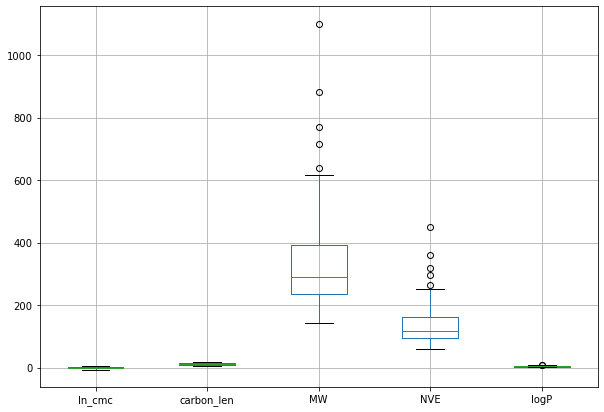

In [10]:
# shows a box plot of all the variables being used 
fig = plt.figure(figsize =(10, 7))
bp = cmc_data.boxplot(column = ["ln_cmc", "carbon_len", "MW", "NVE", "logP"])
plt.show()

In [11]:
# uses the linear mixed model to get values for coefficents for each descriptor, a y-intercept and a correction to
# the model depending on the head group
md = smf.mixedlm("ln_cmc ~ carbon_len + MW + NVE + logP", cmc_data, groups = cmc_data["func_group"])
mdf = md.fit(method = ["lbfgs"])
print(mdf.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: ln_cmc   
No. Observations: 118     Method:             REML     
No. Groups:       11      Scale:              0.3537   
Min. group size:  5       Log-Likelihood:     -139.8704
Max. group size:  40      Converged:          Yes      
Mean group size:  10.7                                 
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    10.249    0.893 11.479 0.000  8.499 11.999
carbon_len   -0.249    0.161 -1.540 0.124 -0.565  0.068
MW           -0.074    0.061 -1.230 0.219 -0.193  0.044
NVE           0.183    0.148  1.239 0.215 -0.107  0.473
logP         -1.435    0.324 -4.429 0.000 -2.071 -0.800
Group Var     3.834    3.222                           



In [12]:
# shows the fixed variables found in the relationship and the correction to the intercept for each head group
fixed_grad = mdf.params
random_inter = mdf.random_effects

print("Fixed Effect:")
print(fixed_grad)
print("\n")

print("Random effect:")
print(random_inter)

Fixed Effect:
Intercept     10.249207
carbon_len    -0.248513
MW            -0.074425
NVE            0.183075
logP          -1.435398
Group Var     10.842247
dtype: float64


Random effect:
{'CO2Na': Group   -0.946956
dtype: float64, 'Carboxylic Acid': Group   -0.135361
dtype: float64, 'Ethoxylates': Group   -4.345296
dtype: float64, 'NH3Ac': Group   -0.770136
dtype: float64, 'NH3Cl': Group   -0.730377
dtype: float64, 'NMe2NBzCl': Group    2.557721
dtype: float64, 'NMe3Br': Group    1.184623
dtype: float64, 'OSO3Na': Group    0.491186
dtype: float64, 'PyBr': Group    2.238253
dtype: float64, 'SO3H': Group    0.00182
dtype: float64, 'SO3Na': Group    0.454523
dtype: float64}


*Predictions using Linear Mixed Model for all data*

*Calculates average statistics values*

In [13]:
rmse_ns, co_det_ns, mae_ns = lmm_stats_average(cmc_data, "carbon_len", "MW", "NVE", "logP", 0.7, True)

RMSE Mean:  40.66
Coeff of Det Mean:  0.62
MAE Mean:  13.69




*Plots only test data* 

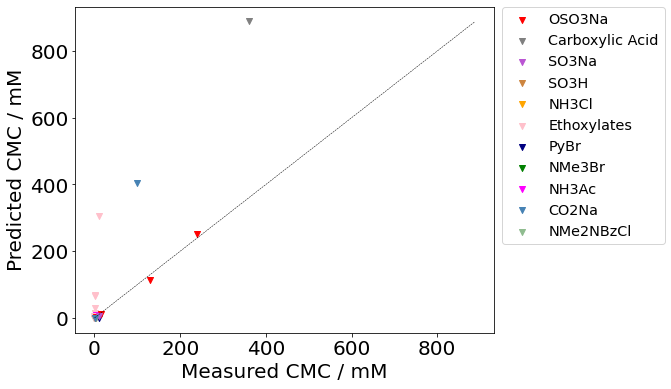

In [14]:
pred, meas, hg, was_test = lmm_model(cmc_data, "carbon_len", "MW", "NVE", "logP", 0.7, False)

pred_meas_test_plot(pred, meas, 6000, 6000, colours, hg, "lmm_test_pred_meas.png", False)

*Plots all data*

In [15]:
# predicts CMC values using relationship found from linear mixed method
pred_lmm, diff_lmm, was_test_lmm = pred_true_cmc_data_lmm(cmc_vals, func_group, fixed_grad, random_inter, 
                                                          carbon_len, mol_weight, val_elec, logp_vals, 
                                                          "carbon_len", "MW", "NVE", "logP", startfunc_pos, 
                                                          endfunc_pos, head_group, was_test, True)

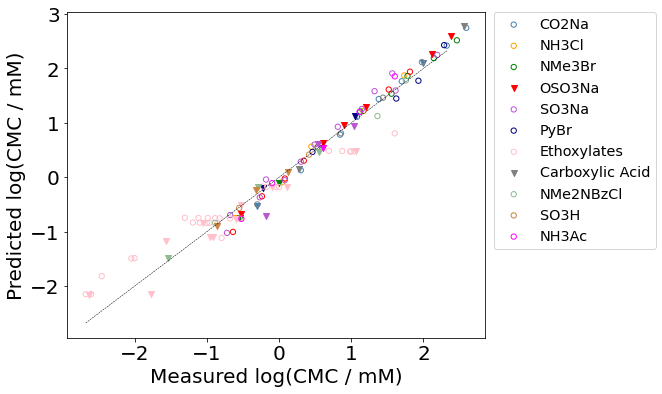

In [16]:
# plots predicted values against measured values
pred_meas_cmc_plotter(pred_lmm, cmc_vals, 600, 600, was_test_lmm, True, colours, head_group, 
                      "lmm_pred_meas_log.png", False)

***How model predicts without the correction to the intercept***

*Calculates average statistics values*

In [17]:
rmse_ns_nocorr, co_det_ns_nocorr, mae_ns_nocorr = lmm_stats_average(cmc_data, "carbon_len", "MW", "NVE", "logP",
                                                                    0.7, False)

RMSE Mean:  126.11
Coeff of Det Mean:  0.01
MAE Mean:  49.19




*Plots only test data*

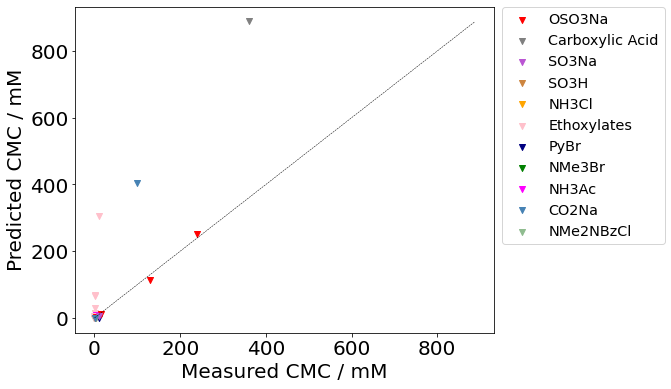

In [18]:
pred_nocorr, meas_nocorr, hg_nocorr, was_test_nocorr = lmm_model(cmc_data, "carbon_len", "MW", "NVE", "logP", 0.7, 
                                                                 False)

pred_meas_test_plot(pred_nocorr, meas_nocorr, 6000, 6000, colours, hg_nocorr, "lmm_test_pred_meas.png", False)

*Plots all data*

In [19]:
# predicts CMC values using relationship found from linear mixed method
pred_nocorr, diff_nocorr, was_test_nocorr = pred_true_cmc_data_lmm(cmc_vals, func_group, fixed_grad, random_inter, 
                                                          carbon_len, mol_weight, val_elec, logp_vals, 
                                                          "carbon_len", "MW", "NVE", "logP", startfunc_pos, 
                                                          endfunc_pos, head_group, was_test, False)

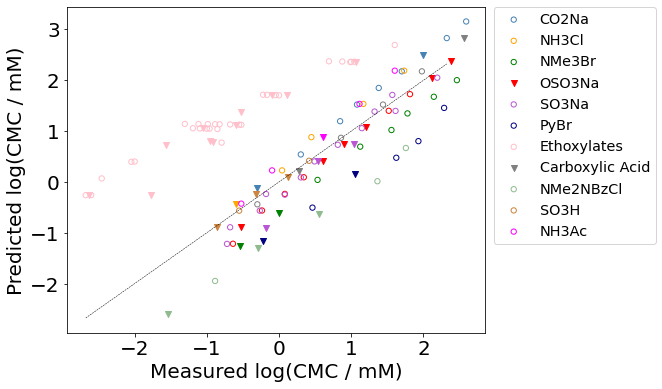

In [20]:
# plots predicted values against measured values
pred_meas_cmc_plotter(pred_nocorr, cmc_vals, 6000, 6000, was_test_nocorr, True, colours, head_group, 
                      "lmm_nocorr_pred_meas_log.png", False)

### Separating ethoxylates

The ethoxylates did not show the same gradient as the rest of the head groups so this has been separated to see if their is an improvement to the prediction

In [21]:
# creates new lists of all information required, excluding ethoxylates
func_group_sep = []; carbon_len_sep = []; MW_sep = []; NVE_sep = []; logP_sep = []; peoe_vsa6_sep = []
total_ic_sep = []; cmc_all_sep = []; ln_cmc_sep = []; indices = []

for ind, gr in enumerate(func_group):
    if gr != "Ethoxylates":
        indices.append(ind)
        func_group_sep.append(gr); carbon_len_sep.append(carbon_len[ind]); MW_sep.append(mol_weight[ind])
        NVE_sep.append(val_elec[ind]); logP_sep.append(logp_vals[ind]); cmc_all_sep.append(cmc_vals_all[ind])
        ln_cmc_sep.append(ln_cmc_vals[ind])

In [22]:
endfunc_pos2 = []
startfunc_pos2 = [0]

# finds index where each head group starts and ends 
for ind, func in enumerate(func_group_sep):  # loops through list of head groups
    if ind < (len(func_group_sep)-1) and func != func_group_sep[ind+1]:
        startfunc_pos2.append(ind+1)
        endfunc_pos2.append(ind+1)
    elif ind == (len(func_group_sep)-1): # on the last one, only append to end position list
        endfunc_pos2.append(ind+1)

In [23]:
# creates new list with name of all head groups being used
head_group_sep = []
for head in func_group_sep:
    if head not in head_group_sep:
        head_group_sep.append(head)

In [24]:
# puts CMC values back into a list of lists
cmc_sep = []
for num in range(len(head_group_sep)): 
    indiv_head = []    
    for cmc in cmc_all_sep[startfunc_pos2[num]:endfunc_pos2[num]]:
        indiv_head.append(cmc) # reassigns the predicted value back to the head group associated with it
    cmc_sep.append(indiv_head)

### LMM results after separating ethoxylates

In [25]:
# creates new data frame without the ethoxylate head group
cmc_data2 = pd.DataFrame(func_group_sep, columns = ["func_group"])
cmc_data2["carbon_len"] = carbon_len_sep; cmc_data2["CMC"] = cmc_all_sep; cmc_data2["ln_cmc"] = ln_cmc_sep
cmc_data2["MW"] = MW_sep; cmc_data2["NVE"] = NVE_sep; cmc_data2["logP"] = logP_sep

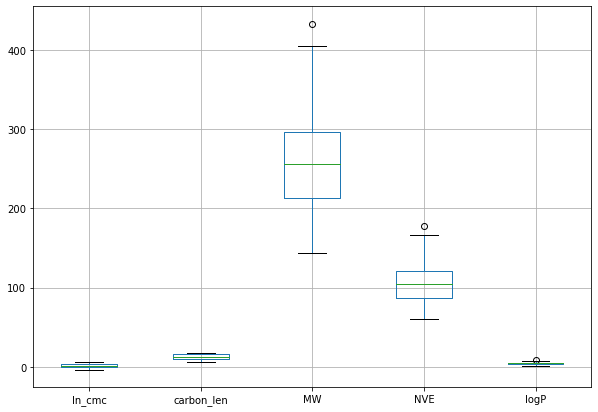

In [26]:
# box plot showing distribution of variables being used
fig = plt.figure(figsize =(10, 7))
bp = cmc_data2.boxplot(column = ["ln_cmc", "carbon_len", "MW", "NVE", "logP"])
plt.show()

In [27]:
# runs linear mixed model without ethoxylates
md = smf.mixedlm("ln_cmc ~ carbon_len + MW + NVE + logP", cmc_data2, groups = cmc_data2["func_group"])
mdf_sep = md.fit(method = ["lbfgs"])
print(mdf_sep.summary())

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: ln_cmc  
No. Observations: 78      Method:             REML    
No. Groups:       10      Scale:              0.0709  
Min. group size:  5       Log-Likelihood:     -37.7277
Max. group size:  16      Converged:          Yes     
Mean group size:  7.8                                 
------------------------------------------------------
            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept   12.912    1.522  8.486 0.000  9.930 15.894
carbon_len  -0.343    0.098 -3.511 0.000 -0.534 -0.151
MW          -0.030    0.052 -0.583 0.560 -0.131  0.071
NVE         -0.004    0.162 -0.023 0.982 -0.321  0.314
logP         0.279    0.728  0.383 0.702 -1.148  1.706
Group Var    0.900    2.052                           



In [28]:
# shows the fixed variables found in the relationship and the correction to the intercept for each head group
fixed_grad_sep = mdf_sep.params
random_inter_sep = mdf_sep.random_effects

print("Fixed Effect:")
print(fixed_grad_sep)
print("\n")

print("Random effect:")
print(random_inter_sep)

Fixed Effect:
Intercept     12.912123
carbon_len    -0.342868
MW            -0.030054
NVE           -0.003661
logP           0.279004
Group Var     12.692766
dtype: float64


Random effect:
{'CO2Na': Group   -0.311366
dtype: float64, 'Carboxylic Acid': Group    0.373705
dtype: float64, 'NH3Ac': Group   -1.171357
dtype: float64, 'NH3Cl': Group   -1.131493
dtype: float64, 'NMe2NBzCl': Group    1.544205
dtype: float64, 'NMe3Br': Group   -0.088305
dtype: float64, 'OSO3Na': Group    0.775165
dtype: float64, 'PyBr': Group    0.273088
dtype: float64, 'SO3H': Group   -0.423914
dtype: float64, 'SO3Na': Group    0.160271
dtype: float64}


*Calculates average statistics values*

In [29]:
rmse2_ns, co_det2_ns, mae2_ns = lmm_stats_average(cmc_data2, "carbon_len", "MW", "NVE", "logP", 0.7, True)

RMSE Mean:  13.37
Coeff of Det Mean:  0.96
MAE Mean:  6.06




*Plots only test data*

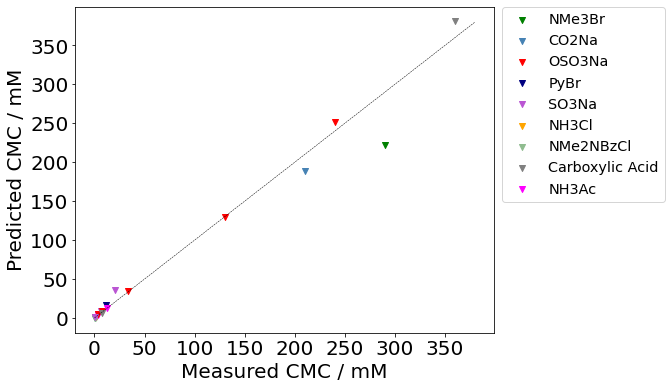

In [30]:
pred_sep, meas_sep, hg_sep, was_test_sep = lmm_model(cmc_data2, "carbon_len", "MW", "NVE", "logP", 0.7, True)

pred_meas_test_plot(pred_sep, meas_sep, 600, 600, colours, hg_sep, "lmm_test_sep_pred_meas.png", False)

*Plots all data*

In [31]:
pred_sep_lmm, diff_sep_lmm, was_test_lmm_sep = pred_true_cmc_data_lmm(cmc_sep, func_group_sep, fixed_grad_sep, 
                                                                      random_inter_sep, carbon_len_sep, MW_sep, 
                                                                      NVE_sep, logP_sep, "carbon_len", "MW", 
                                                                      "NVE", "logP", startfunc_pos2, endfunc_pos2, 
                                                                      head_group_sep, was_test_sep, True)

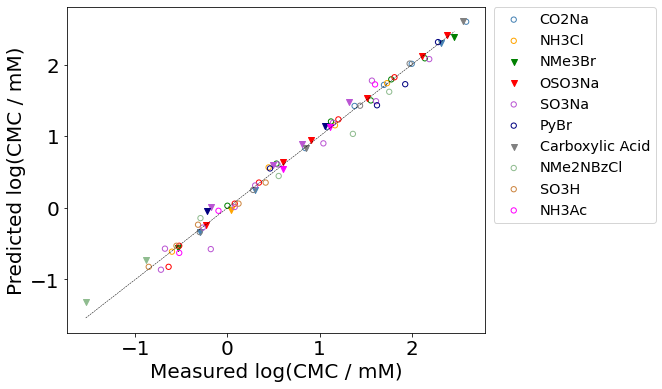

In [32]:
pred_meas_cmc_plotter(pred_sep_lmm, cmc_sep, 600, 600, was_test_lmm_sep, True, colours, head_group_sep, 
                      "sep_mlm_pred_meas_log.png", False)

***How model predicts without the correction to the intercept***

*Calculates average statistics values*

In [33]:
rmse_ns_sep_nocorr, co_det_ns_sep_nocorr, mae_ns_sep_nocorr = lmm_stats_average(cmc_data2, "carbon_len", "MW", 
                                                                                "NVE", "logP", 0.7, False)

RMSE Mean:  34.39
Coeff of Det Mean:  0.74
MAE Mean:  16.71




*Plots only test data*

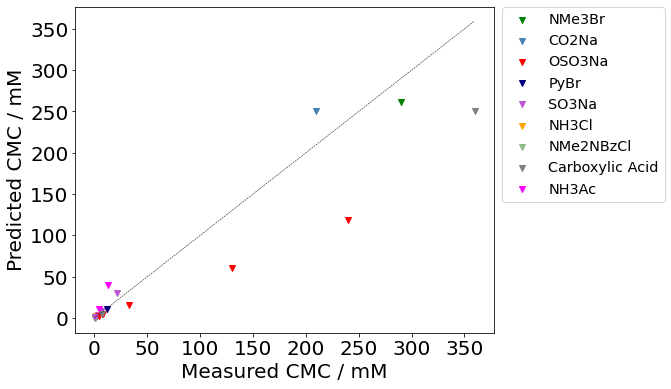

In [34]:
pred_sep_nocorr, meas_sep_nocorr, hg_sep_nocorr, was_test_sep_nocorr = lmm_model(cmc_data2, "carbon_len", "MW", 
                                                                                 "NVE", "logP", 0.7, False)

pred_meas_test_plot(pred_sep_nocorr, meas_sep_nocorr, 600, 600, colours, hg_sep_nocorr, 
                    "lmm_test_sep_pred_meas.png", False)

*Plots all data*

In [35]:
pred_sep_nocorr_lmm, diff_sep_nocorr_lmm, was_test_lmm_sep_nocorr = pred_true_cmc_data_lmm(cmc_sep, func_group_sep,
                                                                                           fixed_grad_sep, 
                                                                                           random_inter_sep, 
                                                                                           carbon_len_sep, MW_sep, 
                                                                                           NVE_sep, logP_sep, 
                                                                                           "carbon_len", "MW", 
                                                                                           "NVE", "logP", 
                                                                                           startfunc_pos2, 
                                                                                           endfunc_pos2, 
                                                                                           head_group_sep, 
                                                                                           was_test_sep_nocorr, 
                                                                                           False)

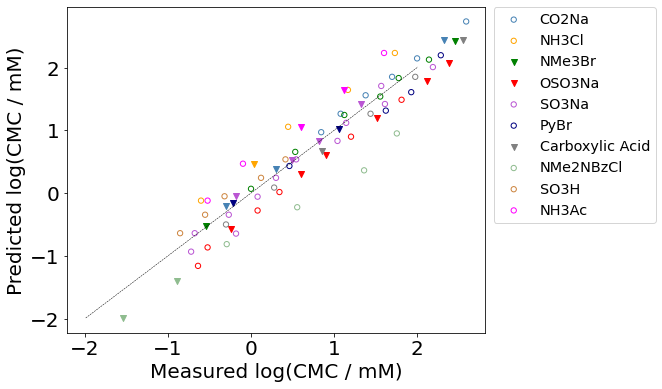

In [36]:
pred_meas_cmc_plotter(pred_sep_nocorr_lmm, cmc_sep, 600, 600, was_test_lmm_sep_nocorr, True, colours, 
                      head_group_sep, "sep_nocorr_mlm_pred_meas_log.png", False)